In [60]:
from warnings import filterwarnings
filterwarnings('ignore')

In [61]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats
plt.style.use('ggplot')

# 1. Data Info

In [118]:
df = pd.read_csv("C:/student_habits_performance.csv")
df

,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,S1000,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Master,Average,8,Yes,56.2
1,S1001,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,High School,Average,8,No,100.0
2,S1002,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,High School,Poor,1,No,34.3
3,S1003,23,Female,1.0,3.9,1.0,No,71.0,9.2,Poor,4,Master,Good,1,Yes,26.8
4,S1004,19,Female,5.0,4.4,0.5,No,90.9,4.9,Fair,3,Master,Good,1,No,66.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,S1995,21,Female,2.6,0.5,1.6,No,77.0,7.5,Fair,2,High School,Good,6,Yes,76.1
996,S1996,17,Female,2.9,1.0,2.4,Yes,86.0,6.8,Poor,1,High School,Average,6,Yes,65.9
997,S1997,20,Male,3.0,2.6,1.3,No,61.9,6.5,Good,5,Bachelor,Good,9,Yes,64.4
998,S1998,24,Male,5.4,4.1,1.1,Yes,100.0,7.6,Fair,0,Bachelor,Average,1,No,69.7


In [63]:
#check for duplicates
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 0


In [64]:
#Count missing values per column
missing_per_col = df.isnull().sum()
print(missing_per_col)

student_id                        0
age                               0
gender                            0
study_hours_per_day               0
social_media_hours                0
netflix_hours                     0
part_time_job                     0
attendance_percentage             0
sleep_hours                       0
diet_quality                      0
exercise_frequency                0
parental_education_level         91
internet_quality                  0
mental_health_rating              0
extracurricular_participation     0
exam_score                        0
dtype: int64


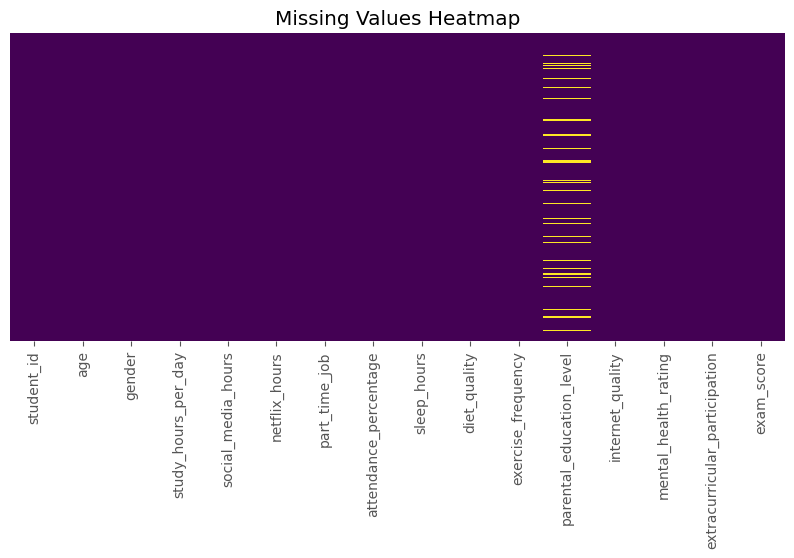

In [65]:
#Visualize missingness (using a heatmap)
plt.figure(figsize=(10, 4))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()

# 2. Data Cleaning 

## 2.1 Fill null values in parental_education_level

### KNN method 

We can also impute missing values in parental_education_level using a **KNN classifier** instead of a simple median/most‐frequent fill. The idea is:
- Separate the rows where parental_education_level is present (“train set” for the classifier) from those where it’s missing (“to‐impute” set).
- Encode all predictors (including gender, part_time_job, etc.) numerically.
- Train a KNN classifier on the non‐null rows to predict the (encoded) parental_education_level.
- Predict the missing rows and write those predictions back into the original DataFrame.

**Label‐encode our categorical target**
- KNN in scikit‐learn expects a numeric target → we use LabelEncoder to convert each unique category (e.g., “HighSchool”, “Bachelor”, “Master+”) into an integer.

In [66]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder #categorial predictors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# 1. Identify “target” and predictor columns
target_col = 'parental_education_level'
predictor_cols = [
    'age',
    'gender',
    'study_hours_per_day',
    'social_media_hours',
    'netflix_hours',
    'part_time_job',
    'attendance_percentage',
    'sleep_hours',
    'diet_quality',
    'exercise_frequency',
    'internet_quality',
    'mental_health_rating',
    'extracurricular_participation',
    'exam_score'
]

Rows where parental_education_level is NOT null → **used to train KNN** 

Rows where parental_education_level IS null → we’ll **predict** these

In [67]:
# 2. Split into “train” (non‐null) and “to‐impute” (null) sets
df_train = df[df[target_col].notna()].copy()
df_missing = df[df[target_col].isna()].copy()

# 3. Split predictor columns numeric vs. categorical
numeric_preds = df_train[predictor_cols].select_dtypes(include=['int64','float64']).columns.tolist()
categorical_preds = [c for c in predictor_cols if c not in numeric_preds]

In [68]:
# 4. Fill missing in df_train and df_missing

# 4.1 Extract median from numeric df_train cols
num_medians = df_train[numeric_preds].median()
#  Extract mode from categorical df_train cols
cat_modes = df_train[categorical_preds].mode().iloc[0]

# 4.2 Fill 
df_train[numeric_preds] = df_train[numeric_preds].fillna(num_medians)
df_train[categorical_preds] = df_train[categorical_preds].fillna(cat_modes)

df_missing[numeric_preds] = df_missing[numeric_preds].fillna(num_medians)
df_missing[categorical_preds] = df_missing[categorical_preds].fillna(cat_modes)
# 5. Encode the target labels
le = LabelEncoder()
y_train = le.fit_transform(df_train[target_col])

# 6. One‐hot encode predictors via pandas.get_dummies (drop_first=True)
X_train = pd.get_dummies(df_train[predictor_cols], drop_first=True)
X_missing = pd.get_dummies(df_missing[predictor_cols], drop_first=True)

The *get_dummies* function in pandas is used for one-hot encoding, converting categorical variables into numerical format. (In our case, we're converting the columns *diet_quality* & *internet_quality*)

In [69]:
# 7. Train the KNN classifier
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train, y_train)

# 8. Predict missing “parental_education_level” and write back
preds_encoded = knn.predict(X_missing)
df.loc[df[target_col].isna(), target_col] = le.inverse_transform(preds_encoded)

In [70]:
#Count missing values per column after KNN classifier
missing_per_col = df.isna().sum()
print(missing_per_col)

student_id                       0
age                              0
gender                           0
study_hours_per_day              0
social_media_hours               0
netflix_hours                    0
part_time_job                    0
attendance_percentage            0
sleep_hours                      0
diet_quality                     0
exercise_frequency               0
parental_education_level         0
internet_quality                 0
mental_health_rating             0
extracurricular_participation    0
exam_score                       0
dtype: int64


## 2.2 Feature Engineering 

In [71]:
# check unique values in each categorical column
cat_cols = ["gender", "part_time_job", "parental_education_level",
            "internet_quality", "diet_quality", "extracurricular_participation"]
for col in cat_cols :
    print(f"{col} : {df[col].unique()}")

gender : ['Female' 'Male' 'Other']
part_time_job : ['No' 'Yes']
parental_education_level : ['Master' 'High School' 'Bachelor']
internet_quality : ['Average' 'Poor' 'Good']
diet_quality : ['Fair' 'Good' 'Poor']
extracurricular_participation : ['Yes' 'No']


In [72]:
#add a total_screen_time column
df["total_screen_time"]= df["social_media_hours"]+ df["netflix_hours"]
df["total_screen_time"]

0      2.3
1      5.1
2      4.4
3      4.9
4      4.9
      ... 
995    2.1
996    3.4
997    3.9
998    5.2
999    4.8
Name: total_screen_time, Length: 1000, dtype: float64

# 3. Data Exploration 

## 3.1 Univariate Analysis 

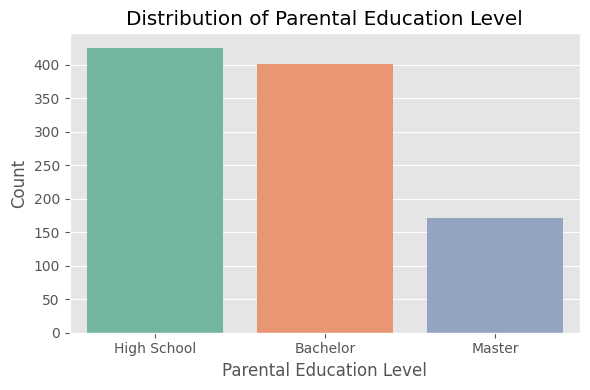

In [73]:
plt.figure(figsize=(6, 4))
sns.countplot(x="parental_education_level", data=df, order=df["parental_education_level"].value_counts().index, palette="Set2")
plt.title("Distribution of Parental Education Level")
plt.xlabel("Parental Education Level")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

Age is between: 17 and 24


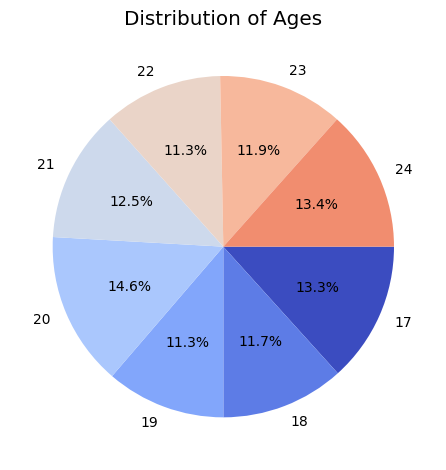

In [74]:
#print out the interval of ages
print(f"Age is between: {df['age'].min()} and {df['age'].max()}")

#pie plot
cmap = plt.cm.coolwarm 
colors = cmap(np.linspace(0, 1, 10))
age_var = df["age"].value_counts().sort_index()
plt.pie(
    age_var,
    labels=age_var.index,
    autopct="%1.1f%%", 
    colors=colors, 
    counterclock=False 
)
plt.title("Distribution of Ages")
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'la distribution des ages des personnes interrogées')

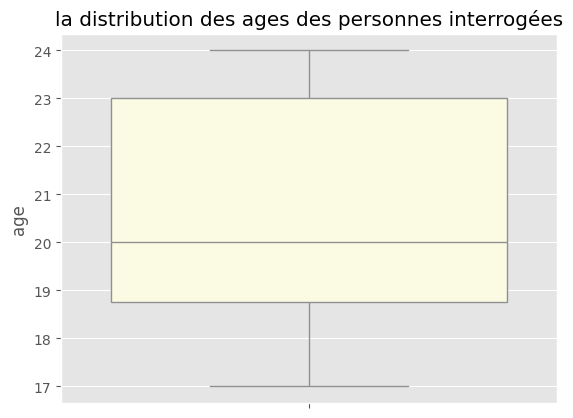

In [75]:
sns.boxplot(y=df['age'], color="lightyellow").set_title('la distribution des ages des personnes interrogées')

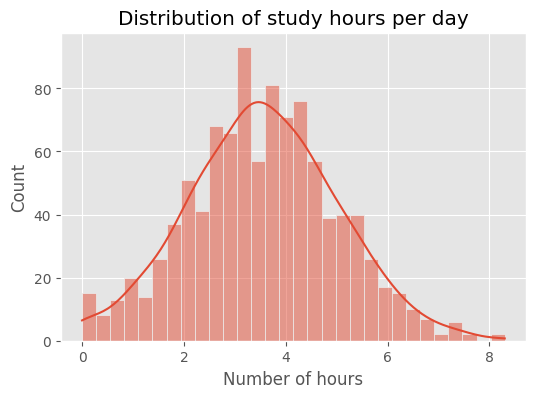

In [76]:
plt.figure(figsize=(6, 4))
sns.histplot(df["study_hours_per_day"], kde=True, bins=30)
plt.title("Distribution of study hours per day")
plt.xlabel("Number of hours")
plt.ylabel("Count")
plt.show()

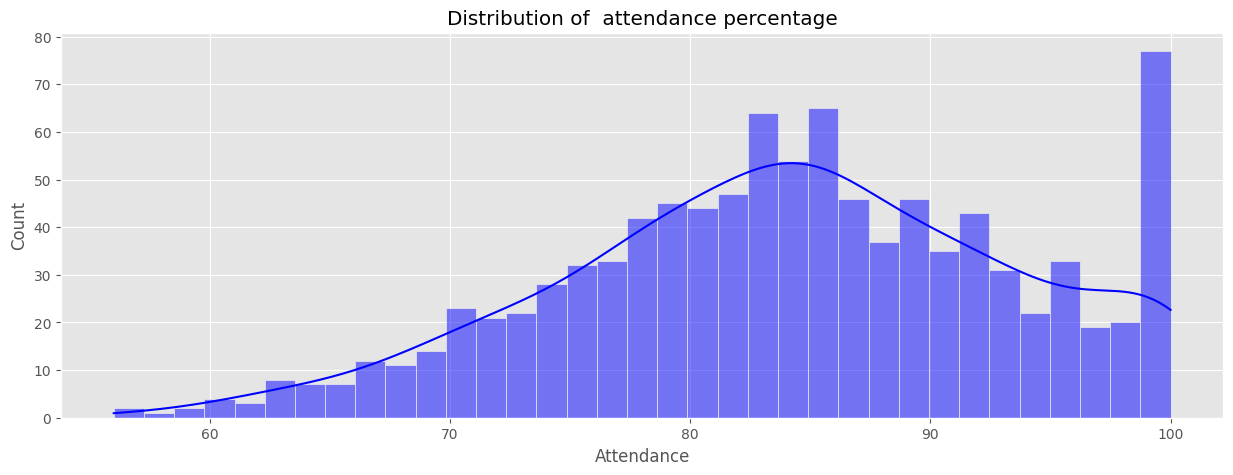

In [77]:
plt.figure(figsize=(15, 5))
sns.histplot(df[ "attendance_percentage"], kde=True, bins=35, color="blue")
plt.title("Distribution of  attendance percentage")
plt.xlabel("Attendance")
plt.ylabel("Count")
plt.show()

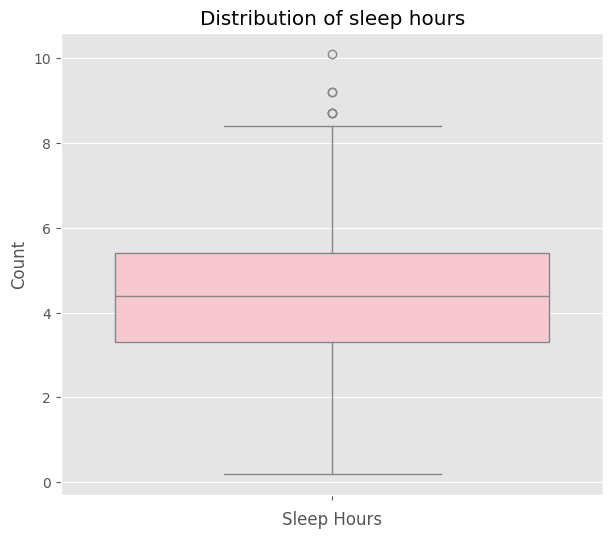

In [78]:
plt.figure(figsize=(7, 6))
sns.boxplot(df["total_screen_time"], color='pink')
plt.title("Distribution of sleep hours")
plt.xlabel("Sleep Hours")
plt.ylabel("Count")
plt.show()

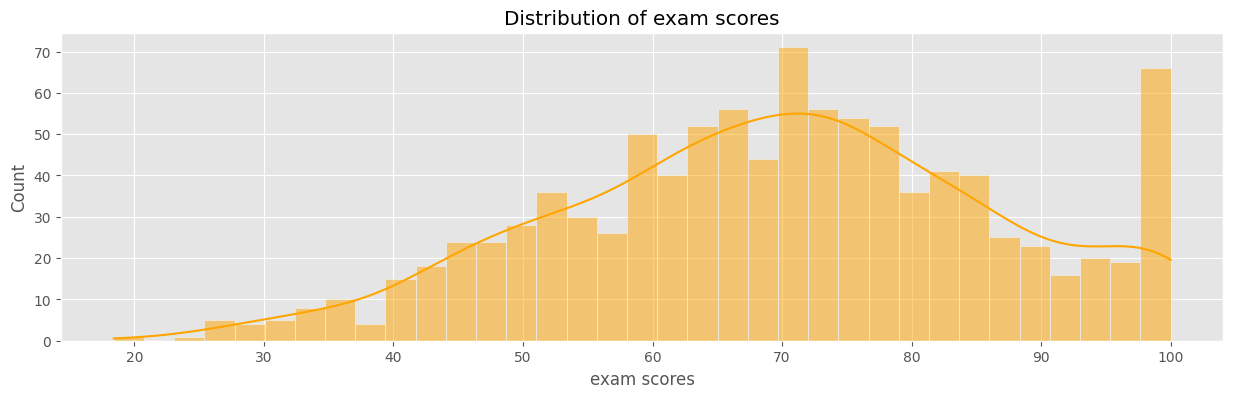

In [79]:
plt.figure(figsize=(15, 4))
sns.histplot(df["exam_score"], kde=True, bins=35, color="orange")
plt.title("Distribution of exam scores")
plt.xlabel("exam scores")
plt.ylabel("Count")
plt.show()

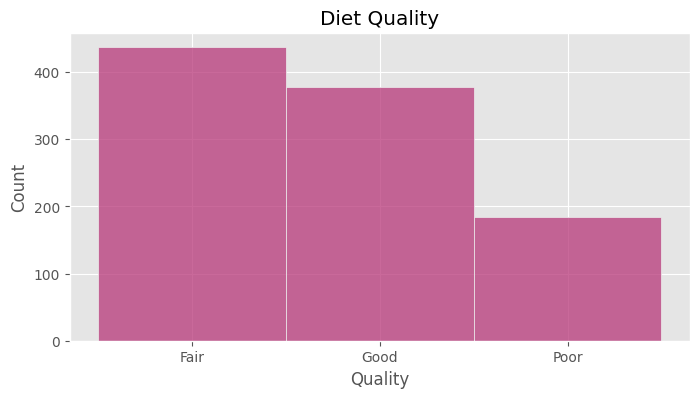

In [80]:
plt.figure(figsize=(8, 4))
cmap = plt.cm.magma
sns.histplot(df["diet_quality"], color=cmap(0.5))
plt.title("Diet Quality")
plt.xlabel("Quality")
plt.ylabel("Count")
plt.show()

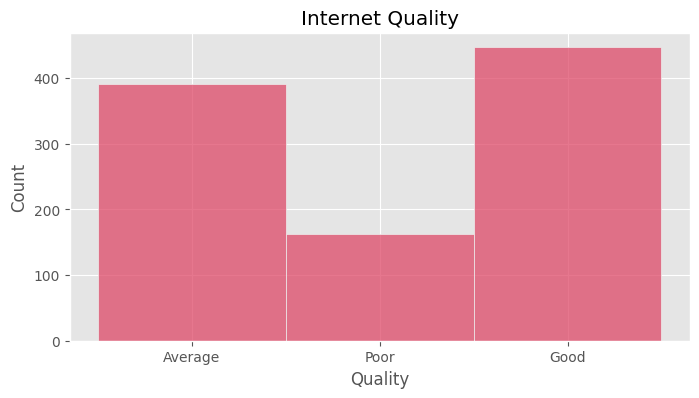

In [81]:
plt.figure(figsize=(8, 4))
cmap = plt.cm.magma
sns.histplot(df["internet_quality"], color=cmap(0.6))
plt.title("Internet Quality")
plt.xlabel("Quality")
plt.ylabel("Count")
plt.show()

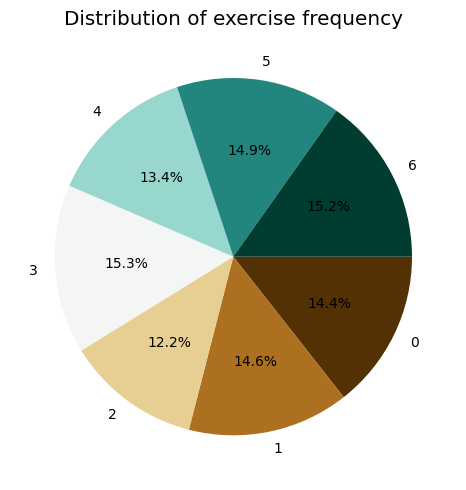

In [82]:
#1. Count how many times each exercise_frequency appears
exercise_count = df["exercise_frequency"].value_counts().sort_index()

#2. Generate  palette colors
cmap = plt.cm.BrBG 
colors = cmap(np.linspace(0, 1, len(exercise_count)))

#3. Pie chart
plt.figure(figsize=(10, 5))
plt.pie(
    exercise_count,
    labels=exercise_count.index,
    autopct="%1.1f%%",
    colors=colors, 
    counterclock=False 
)
plt.title("Distribution of exercise frequency")
plt.tight_layout()
plt.show()

## Outliers Detection

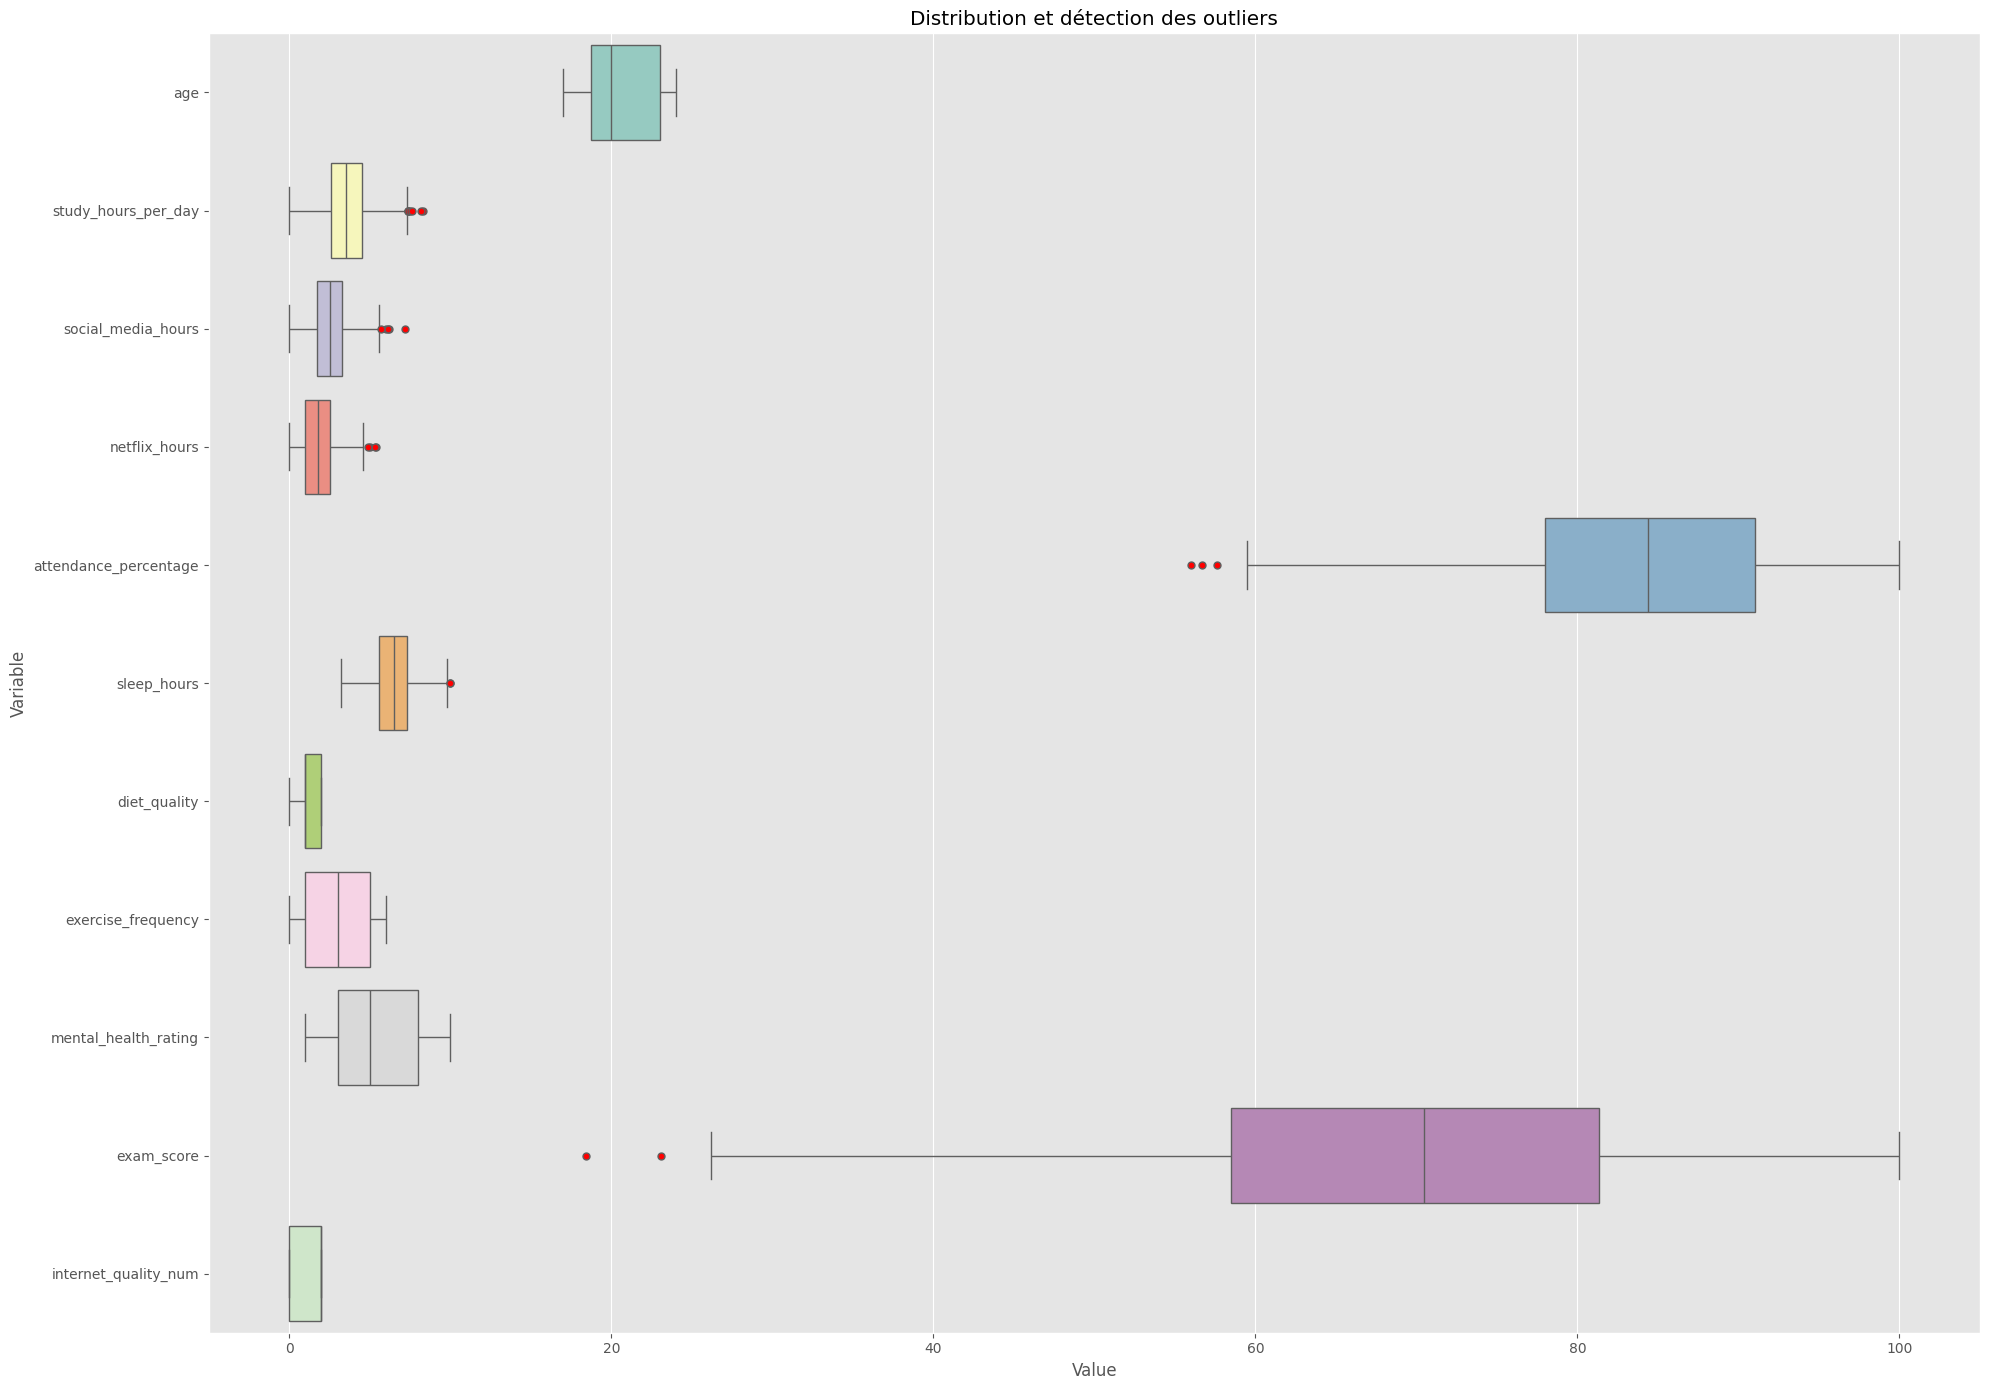

In [83]:
# Define a mapping for internet_quality
df['internet_quality_num'] = df['internet_quality'].map({
    "Poor": 0,
    "Fair": 1,
    "Good": 2
})
# Define a mapping for diet_quality
df['diet_quality'] = df['diet_quality'].map({
    "Poor": 0,
    "Fair": 1,
    "Good": 2
})

# Now include it alongside other numeric columns
numerical_cols = [
    'age',
    'study_hours_per_day',
    'social_media_hours',
    'netflix_hours',
    'attendance_percentage',
    'sleep_hours',
    'diet_quality',
    'exercise_frequency',
    'mental_health_rating',
    'exam_score',
    'internet_quality_num'
]

df_melted = df[numerical_cols].melt(var_name='Variable', value_name='Value')

plt.figure(figsize=(20, 14))
sns.boxplot(
    x='Value',
    y='Variable',
    data=df_melted,
    showfliers=True,
    flierprops={'markerfacecolor': 'red', 'marker': 'o', 'markersize': 5}, 
    palette="Set3"
)
plt.title("Distribution et détection des outliers")
plt.tight_layout()
plt.show()

### Detecting numeric outliers (IQR method)

In [84]:
def detect_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series[(series < lower_bound) | (series > upper_bound)]

In [85]:
# Outliers in “study_hours_per_day”
outliers_study = detect_outliers_iqr(df["study_hours_per_day"])
print("Outliers in study_hours_per_day:\n", outliers_study)

Outliers in study_hours_per_day:
 73     7.4
293    7.4
455    8.3
489    7.4
774    7.5
797    8.2
875    7.6
Name: study_hours_per_day, dtype: float64


In [86]:
# Outliers in “netflix_hours"
outliers_study = detect_outliers_iqr(df["netflix_hours"])
print("Outliers in netflix_hours:\n", outliers_study)

Outliers in netflix_hours:
 81     5.0
556    5.4
822    5.3
887    4.9
Name: netflix_hours, dtype: float64


In [87]:
# Outliers in “social_media_hours"
outliers_study = detect_outliers_iqr(df["social_media_hours"])
print("Outliers in social_media_hours:\n", outliers_study)

Outliers in social_media_hours:
 145    6.2
346    6.0
361    6.1
641    5.7
735    7.2
Name: social_media_hours, dtype: float64


In [88]:
# Outliers in “attendance_percentage"
outliers_study = detect_outliers_iqr(df["attendance_percentage"])
print("Outliers in attendance_percentage:\n", outliers_study)

Outliers in attendance_percentage:
 651    57.6
706    56.7
971    56.0
Name: attendance_percentage, dtype: float64


In [89]:
# Outliers in “exam_score"
outliers_study = detect_outliers_iqr(df["exam_score"])
print("Outliers in exam_score:\n", outliers_study)

Outliers in exam_score:
 265    18.4
327    23.1
Name: exam_score, dtype: float64


### Standardize the values

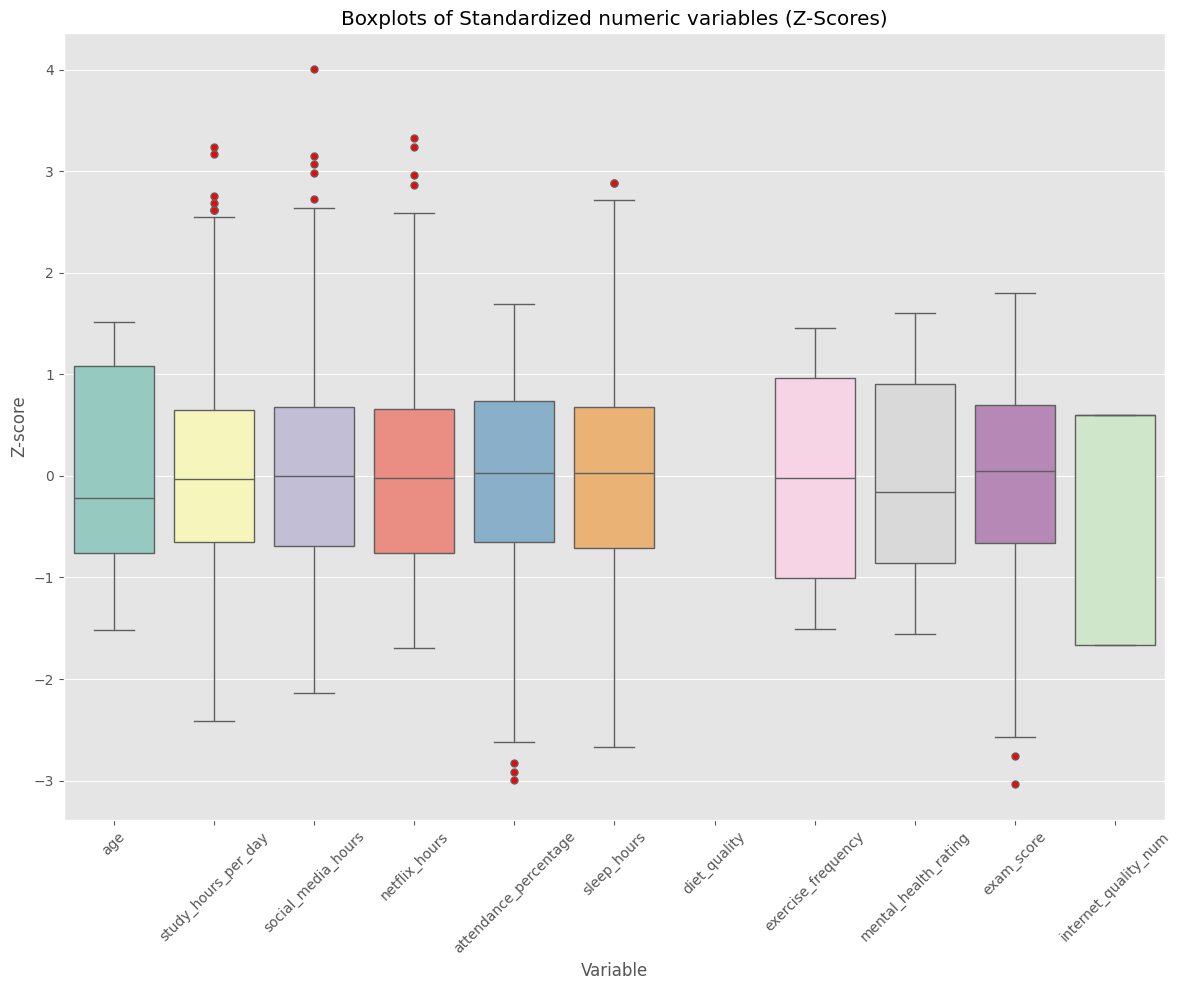

In [90]:
from sklearn.preprocessing import StandardScaler

df['internet_quality_num'] = df['internet_quality'].map({
    "Poor": 0,
    "Fair": 1,
    "Good": 2
})
df['diet_quality'] = df['diet_quality'].map({
    "Poor": 0,
    "Fair": 1,
    "Good": 2
})

numerical_cols = [
    'age',
    'study_hours_per_day',
    'social_media_hours',
    'netflix_hours',
    'attendance_percentage',
    'sleep_hours',
    'diet_quality',
    'exercise_frequency',
    'mental_health_rating',
    'exam_score',
    'internet_quality_num'
]

#Standardize
scaler = StandardScaler()
scaled_array = scaler.fit_transform(df[numerical_cols])
df_scaled = pd.DataFrame(scaled_array, columns=numerical_cols)

# Melt & plot
df_melted_scaled = df_scaled.melt(var_name='Variable', value_name='Z_score')

plt.figure(figsize=(12, 10))
sns.boxplot(
    x='Variable',
    y='Z_score',
    data=df_melted_scaled,
    showfliers=True,
    flierprops={'markerfacecolor': 'red', 'marker': 'o', 'markersize': 5}, 
    palette="Set3"
)
plt.title("Boxplots of Standardized numeric variables (Z-Scores)")
plt.ylabel("Z-score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Bivariate Analysis 

## Numeric–Numeric Relationships

### Corelation between exam scores & total screen time

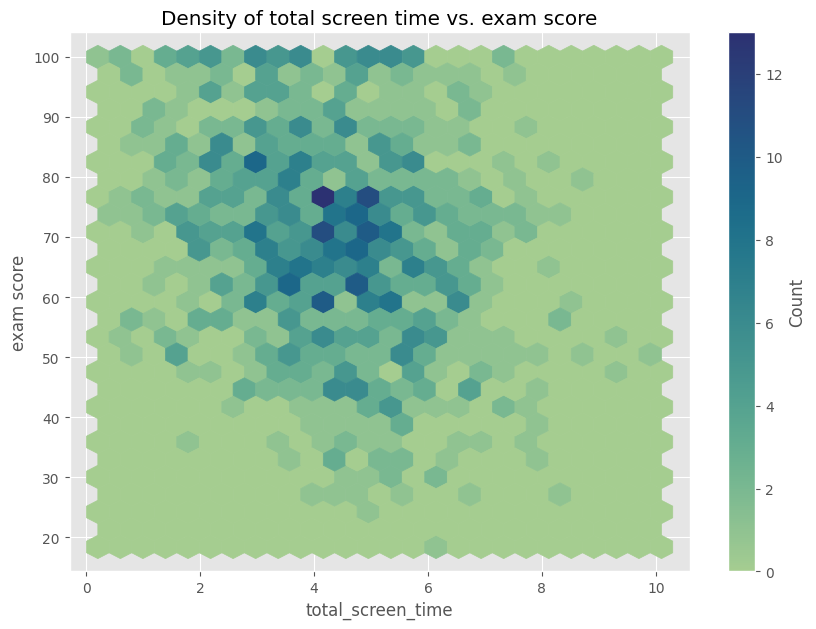

In [91]:
# Hexbin Plot to show point density
plt.figure(figsize=(10, 7))
plt.hexbin(df["total_screen_time"], df["exam_score"], gridsize=25, cmap="crest")
plt.colorbar(label='Count')
plt.xlabel("total_screen_time")
plt.ylabel("exam score")
plt.title("Density of total screen time vs. exam score")
plt.show()

- The darkest hexagons (highest counts) cluster around 4–6 hours of total screen time and exam scores of roughly 60–80, peaking near 4h / 75 points.
- Very low screen time (<2 h) and very high screen time (>8 h) are far less common and show a wider spread of scores. They're often below 60.

- **There’s no strong monotonic trend**. increasing screen time up to the mid-range correlates with better scores, but beyond ~6 h gains plateau or even reverse.

- Notably, perfect scores of 100 also occur for students with 3–6 h of screen time, indicating that this mid-range is where top performers concentrate.

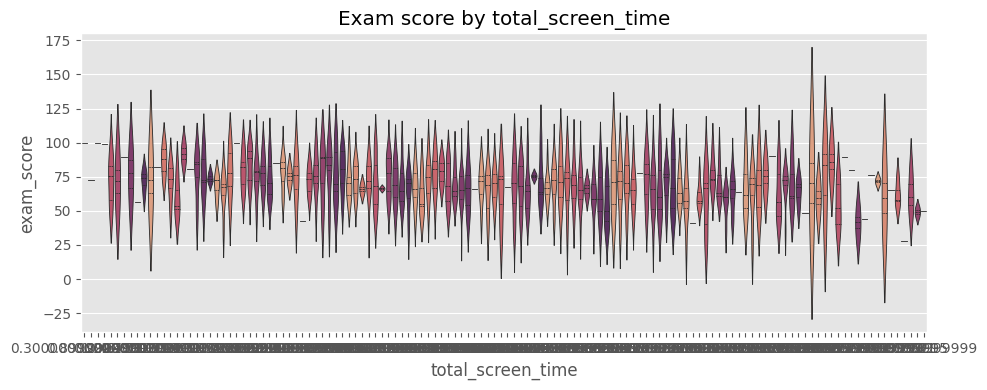

In [92]:
plt.figure(figsize=(10, 4))
sns.violinplot(
    x="total_screen_time",
    y="exam_score",
    data=df,
    inner="quartile", 
    palette=sns.color_palette("flare", 10))
plt.title("Exam score by total_screen_time")
plt.xlabel("total_screen_time")
plt.ylabel("exam_score")
plt.tight_layout()
plt.show()

### Correlation between exam scores & sleep hours

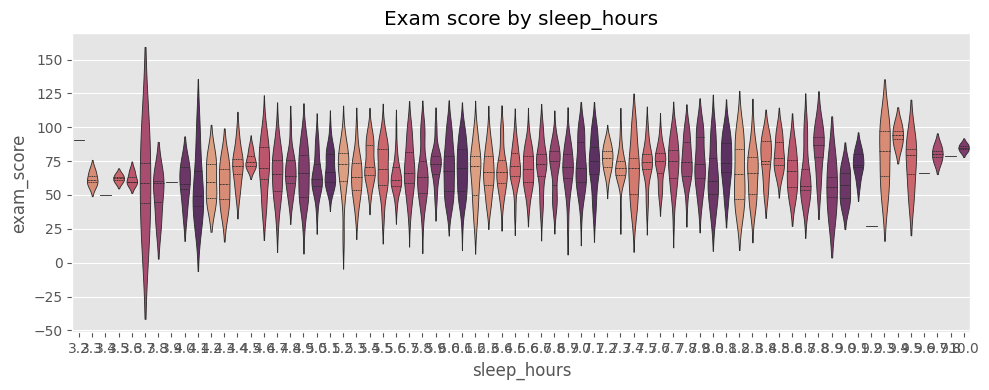

In [93]:
plt.figure(figsize=(10, 4))
sns.violinplot(
    x="sleep_hours",
    y="exam_score",
    data=df,
    inner="quartile", 
    palette=sns.color_palette("flare", 10))
plt.title("Exam score by sleep_hours")
plt.xlabel("sleep_hours")
plt.ylabel("exam_score")
plt.tight_layout()
plt.show()

### Corelation between exam scores & social media hours

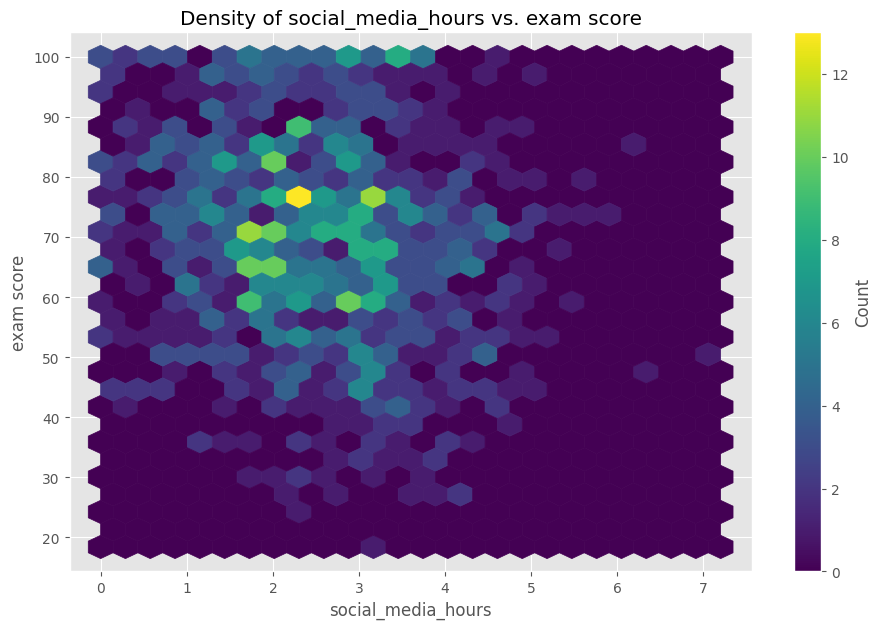

In [94]:
# Hexbin Plot to show point density
plt.figure(figsize=(11, 7))
plt.hexbin(df["social_media_hours"], df["exam_score"], gridsize=25, cmap="viridis")
plt.colorbar(label='Count')
plt.xlabel("social_media_hours")
plt.ylabel("exam score")
plt.title("Density of social_media_hours vs. exam score")
plt.show()

#### Observations 

***Core Density Cluster***: Brightest/yellow region at **2-3.45 hours social media** with scores **65-75%**
- **Performance Peak**: Maximum density at **~3 hours usage** (scores 70-75%)
- **Notable Exception**: Isolated high-performer at 3.45h/100% (statistical outlier)

***The overall trend***
- **Phase 1:** (0-3 hours)
  - Scores increase rapidly from 60% → 75%
  
- **Phase 2:** (3-4 hours)
  - Sustained high performance (70-75%)
  - Minimal score variation despite usage changes
  - Some students score 100 even with with up to 4 hours of total screen time
  
- **Phase 3:** (>4 hours)
  - Scores drop exponentially beyond 4h
  - 5h usage → ~60% scores
  - 7h+ usage → <50% scores (cluster at 45-50%)

#### Interpretations 

**How does score change with social media?**
   - **Low Usage Benefit** (0-3h): 
     - Progressive score improvement (cool → warm colors)
     - Suggests potential cognitive benefits of moderate use
   - **Long usage toxicity** (4h+): 
     - Scores plummet 25-30% between 4-7h usage
     - Complete absence of scores >65% beyond 4.5h

**Outliers**: Group maintaining 45-50% at 6h+ (darker violet) suggests a resilient subgroup unaffected by heavy usage

In [95]:
df[['exam_score', 'social_media_hours']].corr()

,exam_score,social_media_hours
exam_score,1.000000,-0.166733
social_media_hours,-0.166733,1.000000


correlation value = -0.16 <<< 0.5 → Negative correlation

### Exam Score by Daily Study-Hour Interval

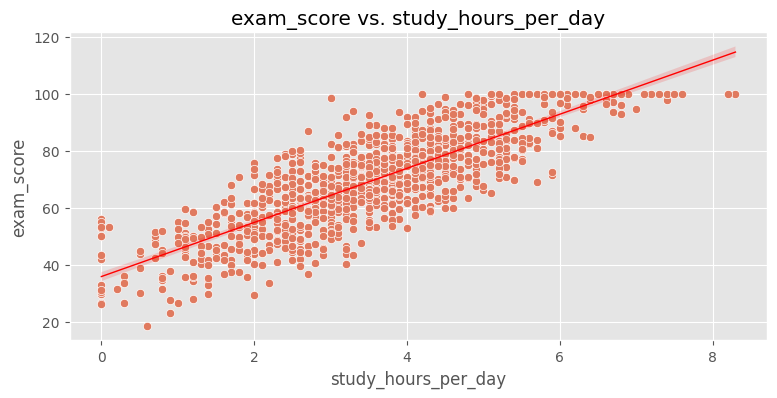

In [96]:
plt.figure(figsize=(9, 4))
sns.scatterplot(x="study_hours_per_day", y="exam_score", data=df, color="#E07A5F")
sns.regplot(x="study_hours_per_day", y="exam_score", data=df, scatter=False, color="red", line_kws={"linewidth": 1})
plt.title(f"{"exam_score"} vs. {"study_hours_per_day"}")
plt.show()


Positive correlation betwen study hours and exam scores

   study_hours_per_day study_interval
0                  0.0            0–2
1                  6.9            > 6
2                  1.4            0–2
3                  1.0            0–2
4                  5.0            4–6
5                  7.2            > 6
6                  5.6            4–6
7                  4.3            4–6
8                  4.4            4–6
9                  4.8            4–6


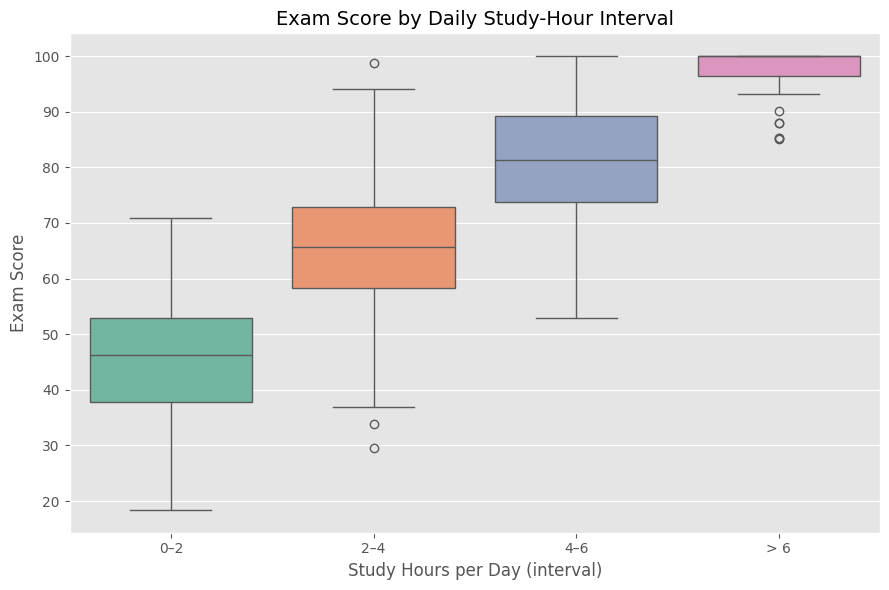

In [97]:
# 1. Define bins and labels
bins = [0, 2, 4, 6, df['study_hours_per_day'].max() + 0.1]  #last bin covers >6
labels = ['0–2', '2–4', '4–6', '> 6']

# 2. Create a new column with cut()
df['study_interval'] = pd.cut(
    df['study_hours_per_day'],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=False
)

# 3. Verify the new column
print(df[['study_hours_per_day', 'study_interval']].head(10))

# 4. Plot a boxplot of exam_score by these intervals
plt.figure(figsize=(9, 6))
sns.boxplot(
    x='study_interval',
    y='exam_score',
    data=df,
    palette='Set2'
)
plt.title("Exam Score by Daily Study-Hour Interval", fontsize=14)
plt.xlabel("Study Hours per Day (interval)", fontsize=12)
plt.ylabel("Exam Score", fontsize=12)
plt.tight_layout()
plt.show()

### Exam Score by Parental Education Level

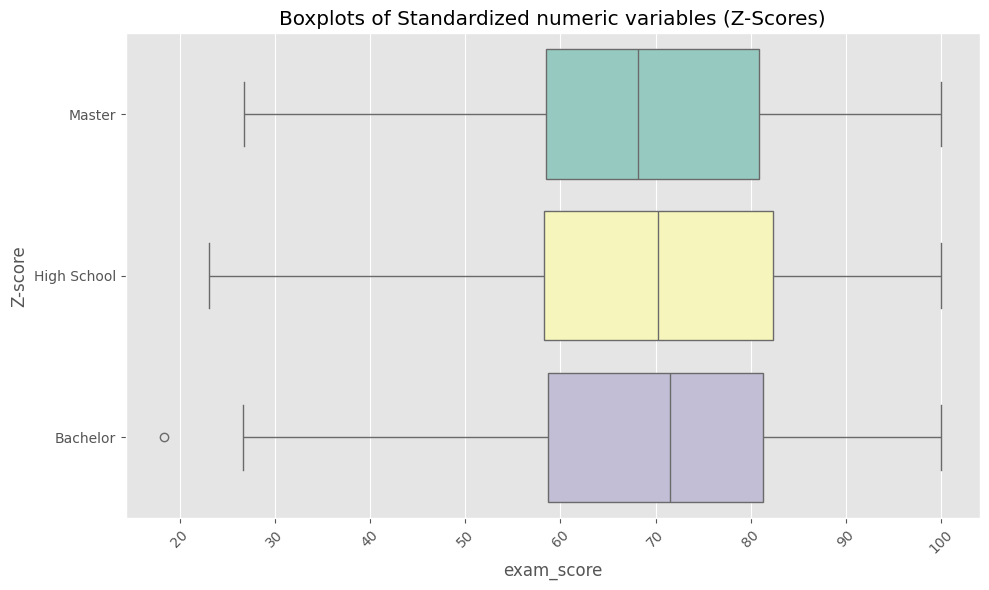

In [98]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    x=df['exam_score'],
    y=df['parental_education_level'],
    data=df,
    showfliers=True,
    palette="Set3"
)
plt.title("Boxplots of Standardized numeric variables (Z-Scores)")
plt.ylabel("Z-score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Central Tendency** (Median & IQR) :

    - Master: median ≈ 68, IQR ~ 63–73.
    - High School: median ≈ 70, IQR ~ 65–75.
    - Bachelor: median ≈ 72, IQR ~ 68–78.

**Note** : IQR  (Interquartile Range) = Q₃ (75th percentile) - Q₁ (25th percentile). This metric defines outlier thresholds where observations beyond [Q₁ - 1.5×IQR, Q₃ + 1.5×IQR] are considered potential outliers.

#### Overlay plots (to observe density of individual observations)

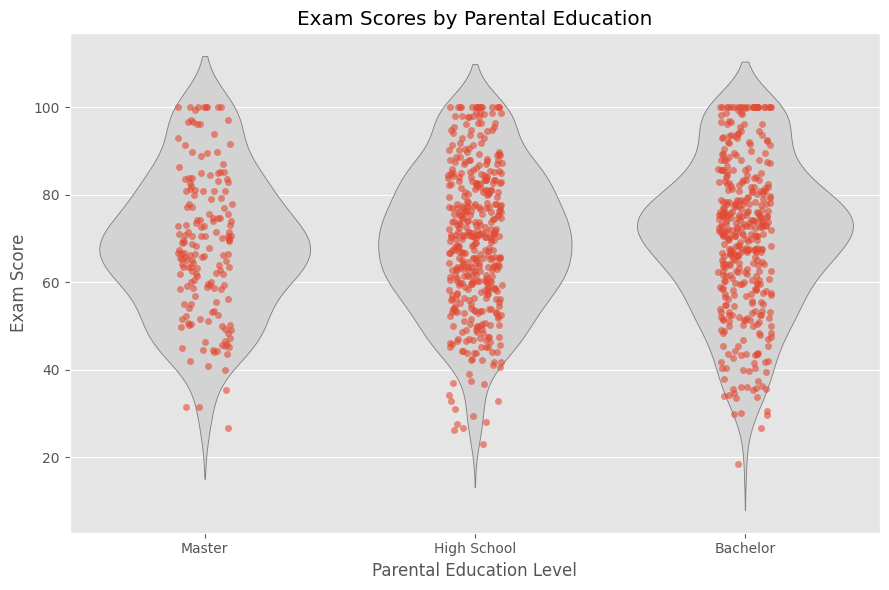

In [99]:
plt.figure(figsize=(9,6))
sns.violinplot(
    x="parental_education_level",
    y="exam_score",
    data=df,
    inner=None, 
    color="lightgray")
sns.stripplot(
    x="parental_education_level",
    y="exam_score",
    data=df,
    jitter=True, 
    alpha=0.6)
plt.title("Exam Scores by Parental Education")
plt.xlabel("Parental Education Level")
plt.ylabel("Exam Score")
plt.tight_layout()
plt.show()

1. Observations

**Shape & Modality**: All three groups show a single dominant peak, indicating unimodal distributions. The “Master” and “Bachelor” violins are slightly wider around the 65–75 score range, while “High School” is more evenly spread between 50 and 80.

**Skewness**:
    - Master: mild right skew (longer tail towards higher scores), with very few low outliers (<35).
    - High School: slight right skew but with evident outliers down to around 20.
    - Bachelor: slight left skew (longer tail toward lower scores) and a handful of very low scores (~10–20).

**Density Peaks**:
- Master: densest around 65–70.
- High School: densest around 70–75.
- Bachelor: densest around 75–80.

**Outliers**: 
The thin “tails” show notable clusters of low scorers in “High School” and “Bachelor”, suggesting small subgroups performing way below the median.

#### Point Plot (to compare group means)

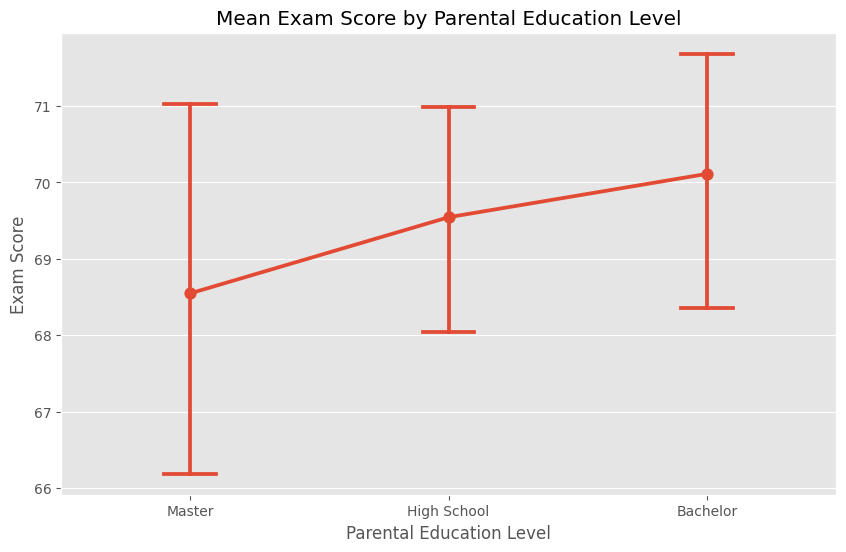

In [100]:
plt.figure(figsize=(10,6))
sns.pointplot(
    x="parental_education_level",
    y="exam_score",
    data=df,
    capsize=.2)
plt.title("Mean Exam Score by Parental Education Level")
plt.xlabel("Parental Education Level")
plt.ylabel("Exam Score")
plt.show()

2. Point Plot Summary:
- Means:
    - Master: ~ 68.5
    - High School: ~ 69.5
    - Bachelor: ~ 70.1

95% Confidence Intervals: show roughly ±0.5–1 point around each mean.

3. Comparative Insights

- Both plots show a clear **upward progression** Master → High School → Bachelor, with average/median scores rising by ~0.5–1 points per level.

- The highest-density regions in each violin (e.g., 75–80 for Bachelor) align closely with the point plot’s mean for that group (~70), confirming that **the bulk of students sit near or above the group mean**.

- Outliers: The violin plot exposes extremely low scores in High School and Bachelor groups, whereas the point plot only plots each group’s average score plus a confidence band around that average, **potentially masking subpopulations with underperformance**.

4. Statistical Implications

- Moderately symmetric violins indicate no severe heterogeneity within groups, but slight skewness and outliers highlight pockets of atypical performance.

- Outlier Impact on Means: A handful of very low scores in the High School and Bachelor groups pull their means marginally downwards. Without these, their true central tendency would be ~ 0.5–1 point higher.

4. **Strategic Interpretation**:
- Actionable Conclusion 1 : **Invest in targeted interventions for students whose parents have High School or bachelor's educations** to reduce low-end outliers and raise overall performance.

- Actionable Conclusion 2 : Leverage **strategies used by the Bachelor group (e.g., study programs or parental engagement models) as best practices** for the Master and High School cohorts to close the performance gap.

### Exam Score vs. attendance_percentage

In [101]:
# Scatterplot:
#  - x: attendance_percentage
#  - y: exam_score
#  - c: total_screen_time (used for the colormap)

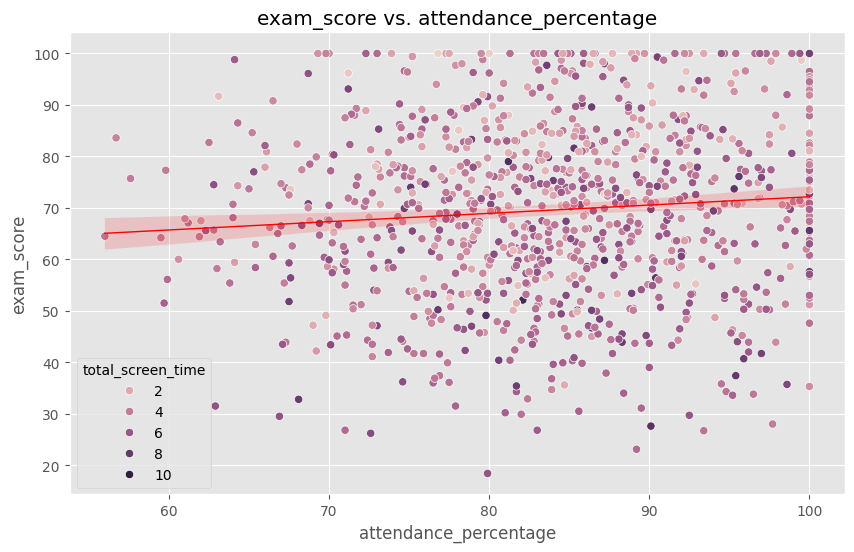

In [102]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x="attendance_percentage", y="exam_score", hue='total_screen_time', data=df, color="#E07A5F")
sns.regplot(x="attendance_percentage", y="exam_score", data=df, scatter=False, color="red", line_kws={"linewidth": 1})
plt.title("exam_score vs. attendance_percentage")
plt.show()

### how do student exam scores are related to their class attendance percentage and their level of screen time?

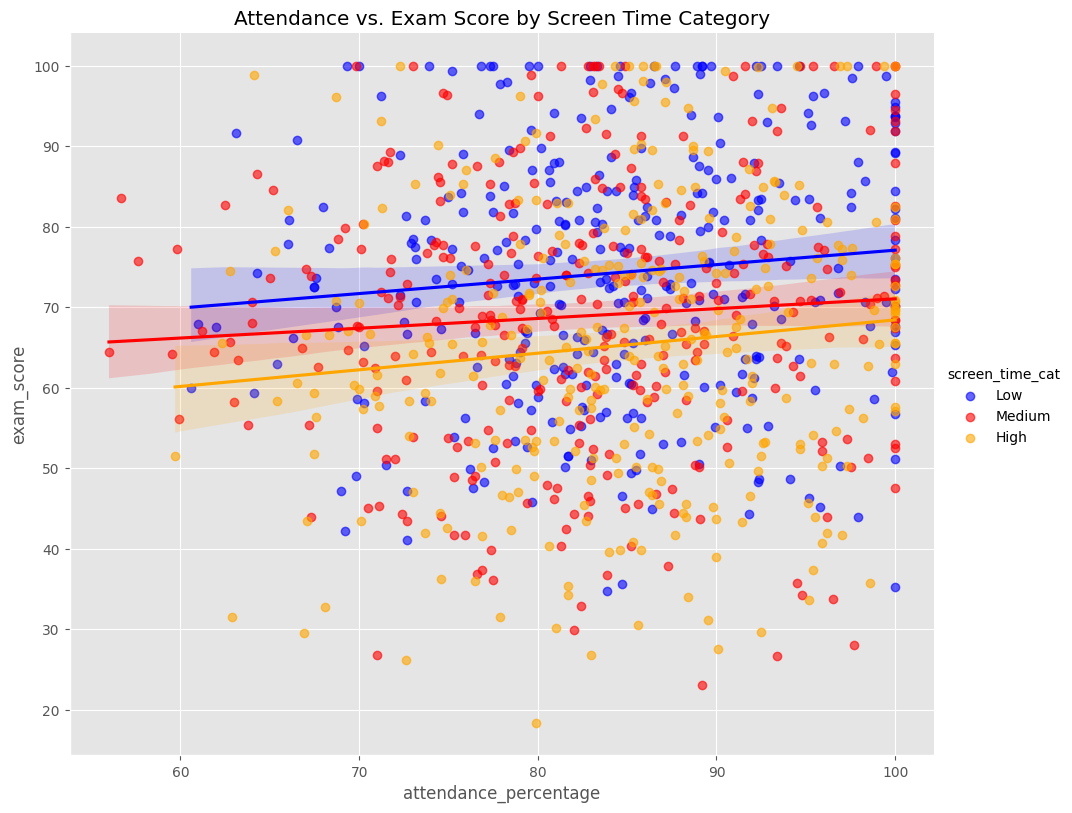

In [103]:
## Create a high/low screen‑time category
df['screen_time_cat'] = pd.qcut(df.total_screen_time, 3, labels=['Low','Medium', 'High'])
sns.lmplot(
    data=df,
    x='attendance_percentage',
    y='exam_score',
    hue='screen_time_cat',
    palette={'Low':'blue','Medium' : 'red' ,'High':'orange'},
    height=8, 
    aspect=1.2,
    scatter_kws={'alpha':0.6}
)
plt.title('Attendance vs. Exam Score by Screen Time Category')
plt.show()

- For all three screen time categories, there is a positive correlation between attendance and exam score. As the attendance_percentage increases, the exam_score also tends to increase. All three regression lines have a positive slope.
- The slopes are very similar, indicating that **the rate with which the exam scores increase is roughly the same all 3 groups**.
- There is considerable scatter in the data points for all groups. This means that while these trends exist, **attendance and screen time aren't the only factors determining a studet's exam score**; other factors are also at play.

**Insights**: 
1. *Attendance is a key to better scores* as it's the most direct and controllable lever for improving scores.
2. *Screen time has a signifcant, independent negative association*. Students with lower screen time often outperform those with higher ones.
For example, at 90% attendance, the predicted score for a "low" screen time student is around 75. While for a "high" screen tiem student it's below 70. *This suggests screen time has a destructive effect on academic performance that is separate from its potential impact on attendance.

**Actionable decisions** : 
- Implement a program to maximize student attendance.
- Develop an initiative to help students manage their screen time effectively.
-  Identify and provide targeted support for the most vulnerable student segment. Students with both low attendance and high screen time (the orange dots in the bottom-left quadrant) are at the highest risk of academic failure. These students should be the top priority for academic counseling and intervention that addresses both behaviors simultaneously.

### Corelation between exam scores & sleep hours

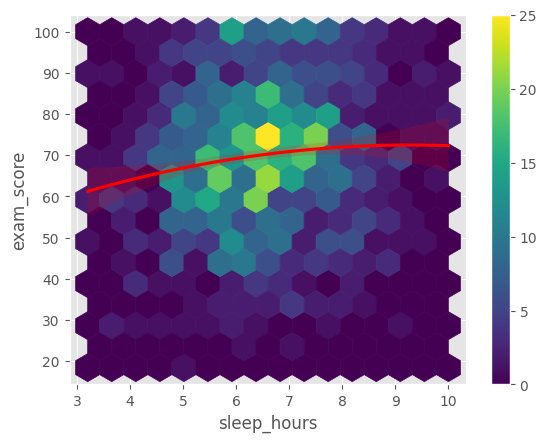

In [104]:
# Add trendline to hexbin
plt.hexbin(df['sleep_hours'], df['exam_score'], gridsize=15, cmap="viridis")
sns.regplot(x='sleep_hours', y='exam_score', data=df, 
            scatter=False, order=2, color='red')  # Quadratic fit
plt.colorbar()

<Axes: xlabel='sleep_hours', ylabel='exam_score'>

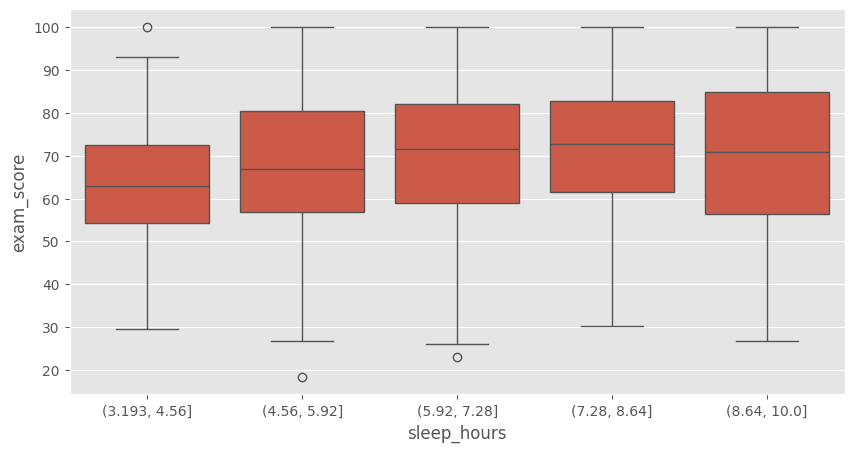

In [105]:
#distribution details
plt.figure(figsize=(10,5))
sns.boxplot(x=pd.cut(df['sleep_hours'], bins=5), y='exam_score', data=df)

Inverted U-shaped relatioship: The plot reveals a non-linear relationship where:
 * Scores *increase* with more sleep up to 7.5-9 hours (optimal zone)
 * Scores *decrease* beyond 9 hours of sleep
-**Optimal Sleep Range**: Peak performance occurs at **7.5-9 hours** of sleep

#### Key observations

- **Critical Sleep Deprivation (3.2-4.6 hrs)**:
  - Extreme score variability (30-93)
  - Majority scores clustered below 70 (score mean=63)
  - Single outlier at 100 indicates exceptional cases exist
  - *Interpretation*: <4.6 hrs sleep causes unpredictable performance but generally poor results

- **Progressive Improvement (4.6-7.5 hrs)**:
  - Density shifts toward higher scores (score mean improves up to 72)
  - *Interpretation*: Each additional hour improves score consistency

- **Peak Performance Zone (7.5-9 hrs)**:
  - Highest density of 80-100 scores 
  - Tight clustering indicates consistent high achievement (Reduced score variability)
  - *Interpretation*: Biological sweet spot for cognitive performance

- **Excessive Sleep (>9 hrs)**:
  - Scores decline to ~71% average
  - Moderate density in 60-80 range 
  - Near absence of 90+ scores
  - *Interpretation*: Oversleeping may indicate underlying health issues or poor study habits

- **Outlier Significance**: The 100-scorer with <4.6hrs sleep suggests:
  - Exceptional cognitive resilience exists
  - Not a replicable strategy for most students
- **The 9hr Threshold**: Sharp performance drop beyond 9hrs warrants investigation into possible confounding factors (e.g., depression, chronic illness)

### Correlation between mental health & exam scores

<Axes: xlabel='mental_health_rating', ylabel='exam_score'>

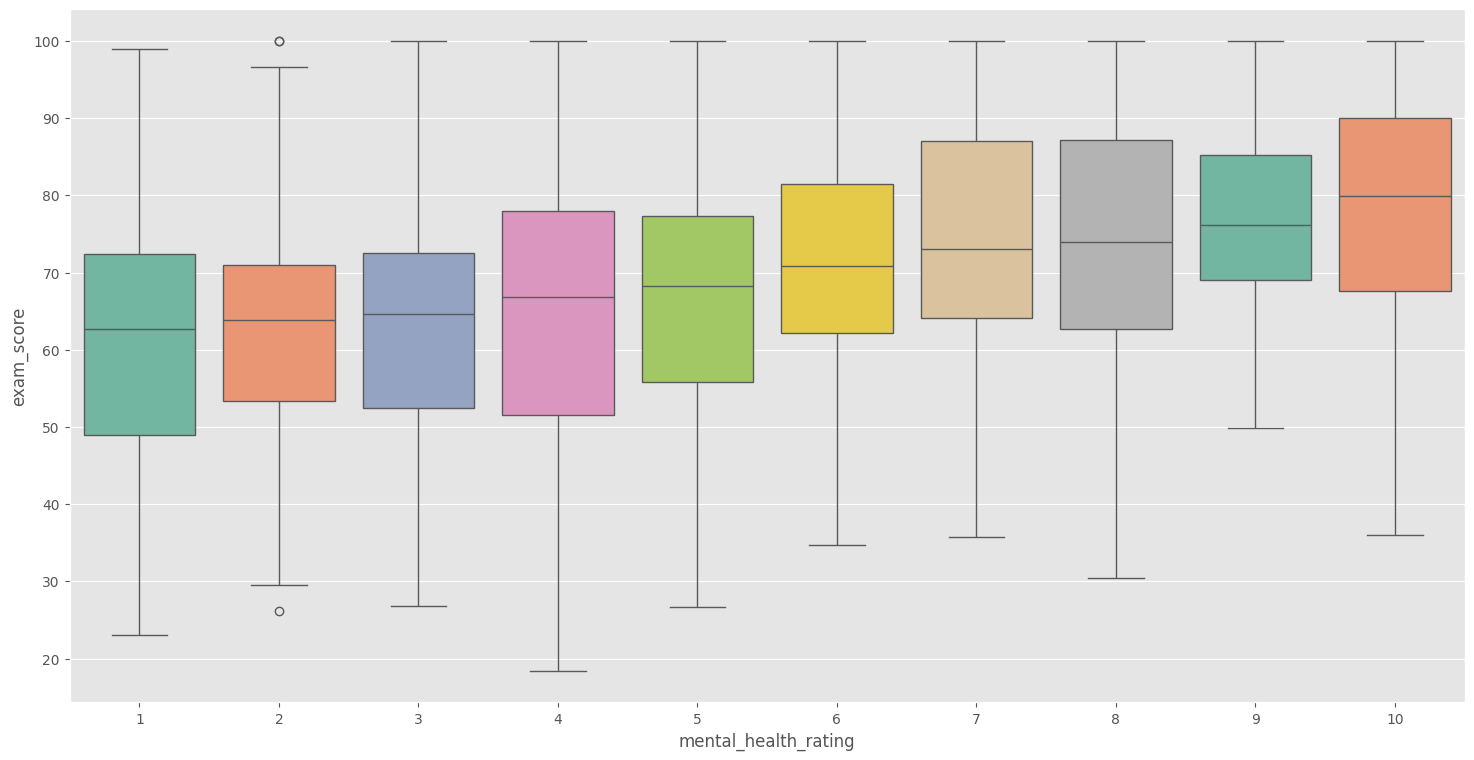

In [106]:
plt.figure(figsize=(18,9))
sns.boxplot(x='mental_health_rating', y='exam_score', data=df, palette="Set2")

### Correlation between mental well-being, Internet Quality & Exam Performance

H0 : exam_score and mental_health_rating independent

In [107]:
from scipy.stats import chi2_contingency
contingency = pd.crosstab( df['mental_health_rating'], df['exam_score'])
chi2_stat, p_val, dol, expected = chi2_contingency(contingency)
alpha = 0.05 #alpha is the error percentage
print("Chi‑square stat = ",chi2_stat)
print("Degrees of freedom = ", dol)
print("p‑value = ", p_val)
#print("Expected frequencies:\n", expected)

if p_val <= alpha:
    print("Reject H₀: Variables are dependent.")
else:
    print("Fail to reject H₀: Variables are independent.")

Chi‑square stat =  4361.562865685401
Degrees of freedom =  4311
p‑value =  0.29129837722591334
Fail to reject H₀: Variables are independent.


### Exam Score vs Internet Quality

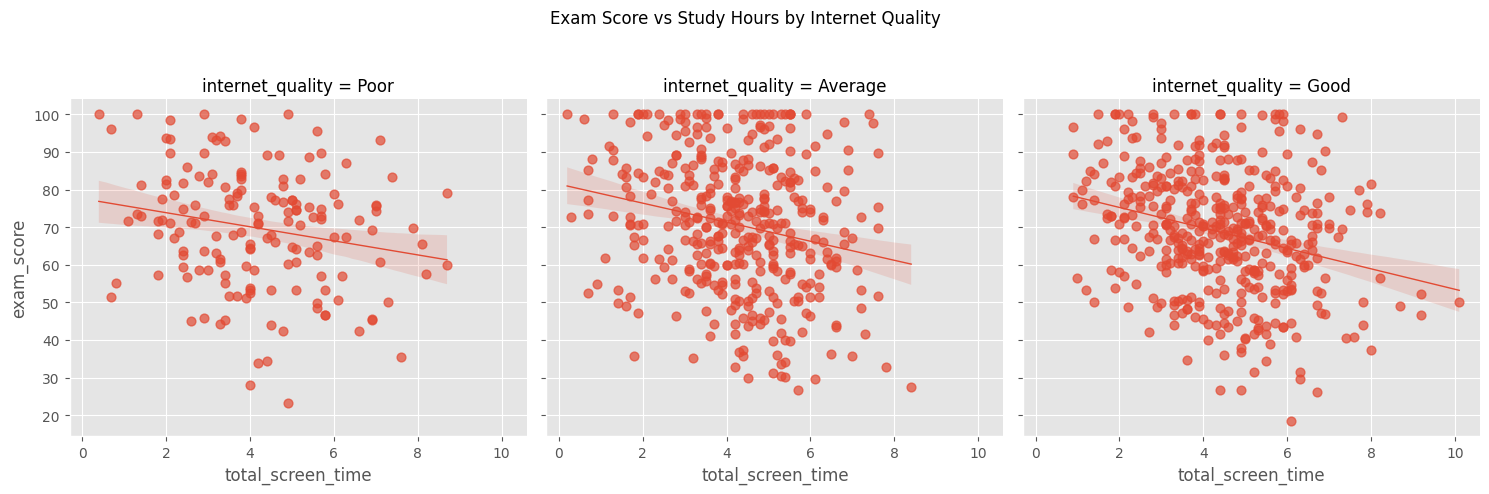

In [108]:
sns.lmplot(
    x="total_screen_time",
    y="exam_score",
    col="internet_quality",
    data=df,
    col_order=["Poor","Average","Good"],
    height=5,
    aspect=1,
    scatter_kws={"s":40, "alpha":0.7},
    line_kws={"lw":1}
)
plt.subplots_adjust(top=0.8)
plt.suptitle("Exam Score vs Study Hours by Internet Quality")
plt.show()

#### For students who scored > 80

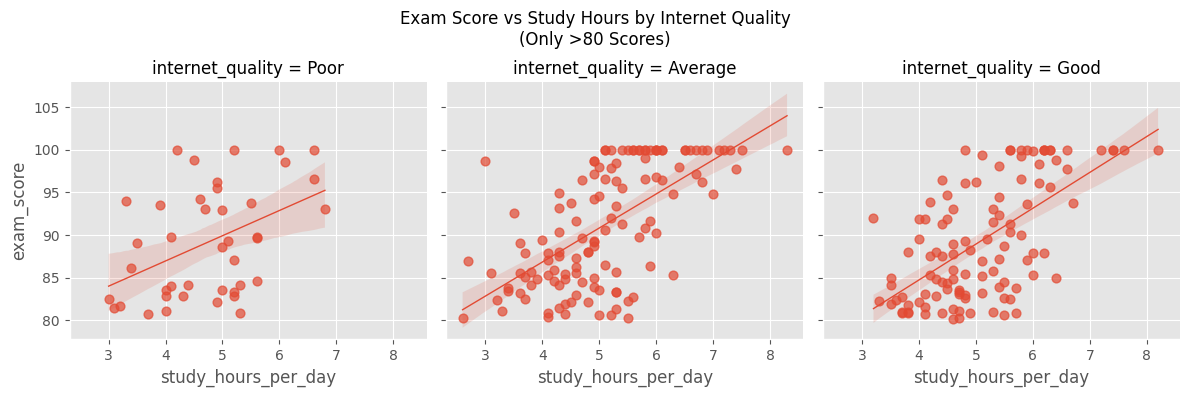

In [109]:
df2 = df[df.exam_score > 80]
sns.lmplot(
    x="study_hours_per_day",
    y="exam_score",
    col="internet_quality",
    data=df2,
    col_order=["Poor","Average","Good"],
    height=4,
    aspect=1,
    scatter_kws={"s":40, "alpha":0.7},
    line_kws={"lw":1}
)
plt.subplots_adjust(top=0.8)
plt.suptitle("Exam Score vs Study Hours by Internet Quality\n(Only >80 Scores)")
plt.show()

There is a strong correlation between study hours and exam scores, independently from the internet quality. The best number of hours 

#### For students who scored < 60

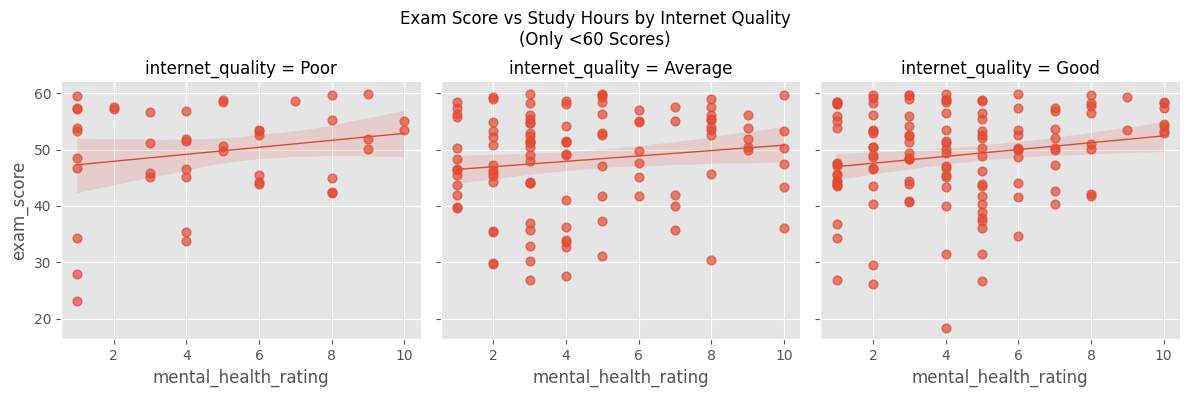

In [110]:
df2 = df[df.exam_score <60]
sns.lmplot(
    x="mental_health_rating",
    y="exam_score",
    col="internet_quality",
    data=df2,
    col_order=["Poor","Average","Good"],
    height=4,
    aspect=1,
    scatter_kws={"s":40, "alpha":0.7},
    line_kws={"lw":1}
)
plt.subplots_adjust(top=0.8)
plt.suptitle("Exam Score vs Study Hours by Internet Quality\n(Only <60 Scores)")
plt.show()

#### How does the mental health affect exam scores? Does the internet quality influence have an influence too? 

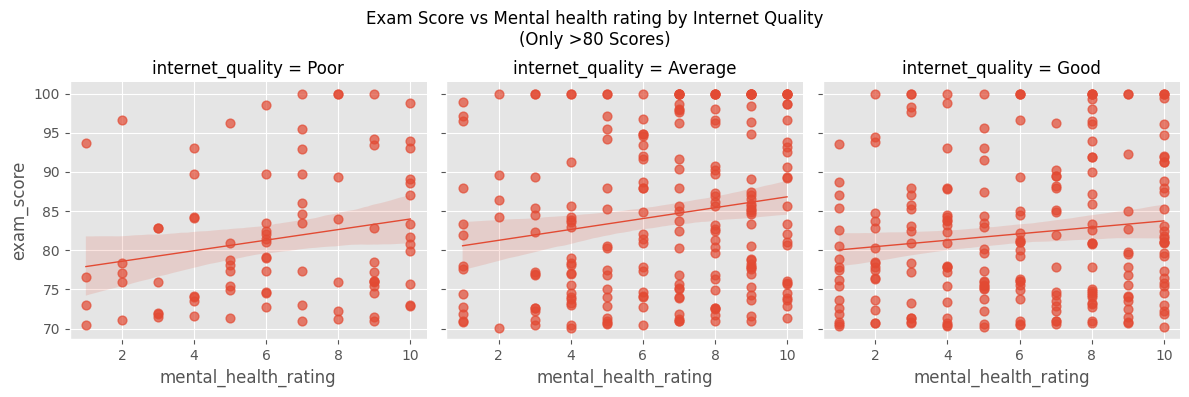

In [111]:
df2 = df[df.exam_score >70]
sns.lmplot(
    x="mental_health_rating",
    y="exam_score",
    col="internet_quality",
    data=df2,
    col_order=["Poor","Average","Good"],
    height=4,
    aspect=1,
    scatter_kws={"s":40, "alpha":0.7},
    line_kws={"lw":1}
)
plt.subplots_adjust(top=0.8)
plt.suptitle("Exam Score vs Mental health rating by Internet Quality\n(Only >80 Scores)")
plt.show()

The data shows a clear pattern: a student's mental well-being is a much stronger predictor of exam success than their internet quality.
1. A significant number of students **with mental health ratings above 6 also achieve high exam scores (often over 80)**. This demonstrates that emotional well-being is a powerful foundation for academic success.
2. **Top-performing students often have high-quality internet, which likely supports their studies through reliable access to resources**. However, this technical advantage does not correlate with better mental health. Students across all internet quality levels report similar well-being, suggesting that a fast connection is a tool for academic achievement, not a driver of emotional resilience.
3. **Personal Factors Can Outweigh Technical Limitations**
The data also reveals important exceptions. Some high-achievers have only modest mental health ratings, possibly due to intense study habits or external pressures. Conversely, other students excel academically with just average internet, highlighting that strong personal strategies and supportive environments can overcome technical disadvantages.

**Actionable Strategy**

To best support students, focus on a dual approach:
- Provide reliable digital infrastructure to ensure all students have the technical tools to perform.
- Invest in programs that build mental resilience, such as stress management workshops or peer support networks.

<Figure size 1800x900 with 0 Axes>

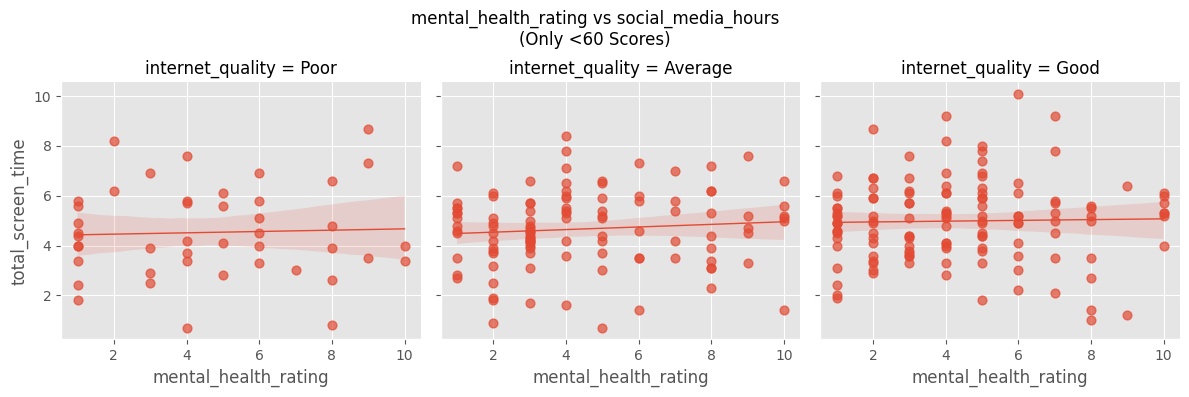

In [112]:
plt.figure(figsize=(18,9))
df2 = df[df["exam_score"] <60]
sns.lmplot(
    x="mental_health_rating",
    y="total_screen_time",
    col="internet_quality",
    data=df2,
    col_order=["Poor","Average","Good"],
    height=4,
    aspect=1,
    scatter_kws={"s":40, "alpha":0.7},
    line_kws={"lw":1}
)
plt.subplots_adjust(top=0.8)
plt.suptitle("mental_health_rating vs social_media_hours\n(Only <60 Scores)")
plt.show()

These charts reveal two key insights:
- **Internet quality and screen time**: Students with better mental health ratings tend to log less screen hours. Among those with average or good internet, a substantial group, spending 4 to 8 hours online, reports low mental-health scores (0–5 out of 10). Conversely, fewer students who spend roughly 2h and a half to 6 hours online achieve higher mental-health ratings.

- **As time on social platforms increases, mental-health scores decline**.

## Time management and its influence on students' scores

### Correlation between exam_score & Mental health rating and exam scores

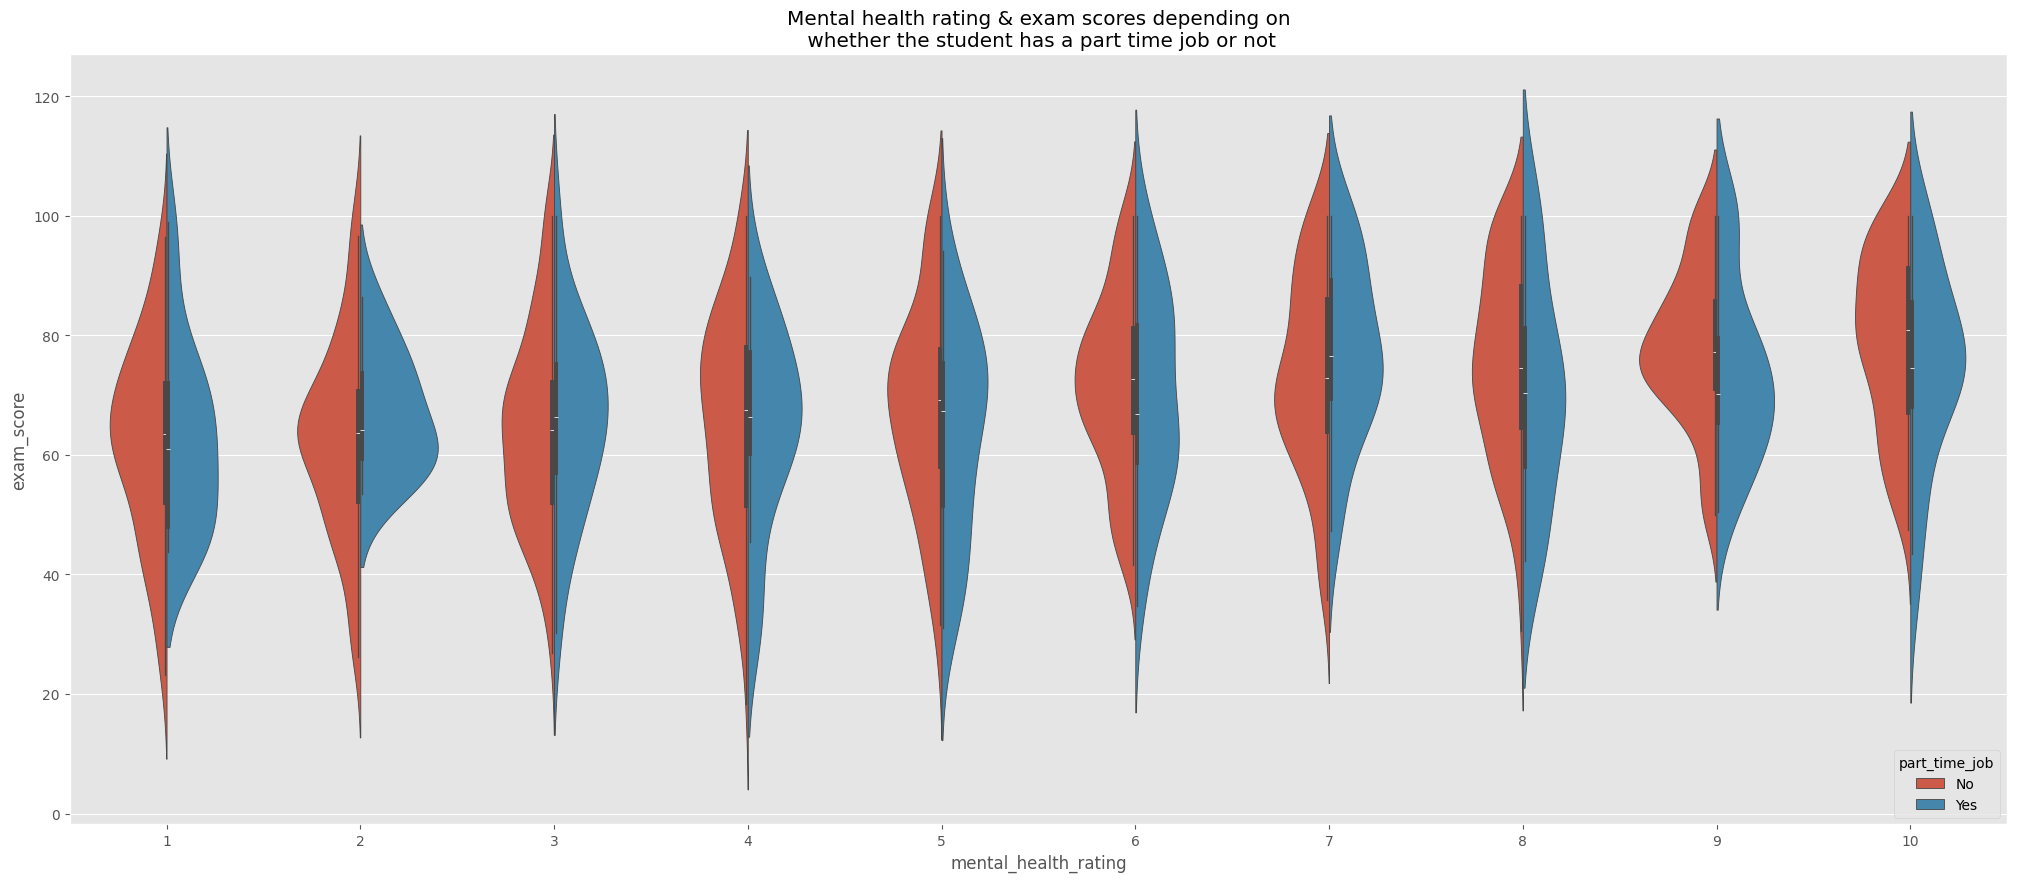

In [113]:
tips = sns.load_dataset("tips")
plt.figure(figsize=(25,10))
sns.violinplot(
  x="mental_health_rating",
  y="exam_score",
  split=True,
  hue= "part_time_job",
  data=df
)
plt.title("Mental health rating & exam scores depending on\n whether the student has a part time job or not")
plt.show()

### Correlation between exam_score & extracurricular_participation

H0 : exam_score and extracurricular_participation are independent

In [114]:
from scipy.stats import chi2_contingency
#1. Build the contingency table
contingency = pd.crosstab( df['exam_score'], df['extracurricular_participation'])
#2. Run the chi-square test
chi2_stat, p_val, dol, expected = chi2_contingency(contingency)
#3. Print results
alpha = 0.05 #alpha is the error percentage
print("Chi‑square stat = ",chi2_stat)
print("Degrees of freedom = ", dol)
print("p‑value = ", p_val)
#print("Expected frequencies:\n", expected)

if p_val <= alpha:
    print("Reject H₀: Variables are dependent.")
else:
    print("Fail to reject H₀: Variables are independent.")

Chi‑square stat =  495.19925364417145
Degrees of freedom =  479
p‑value =  0.29491961845235054
Fail to reject H₀: Variables are independent.


### Correlation between whether the student has a part-time job or not & their exam score

Statistical hypothesis test

H0 : "exam_score and part_time_job are independent"

In [115]:
from scipy.stats import chi2_contingency
contingency = pd.crosstab( df['part_time_job'], df['exam_score'])
chi2_stat, p_val, dol, expected = chi2_contingency(contingency)
alpha = 0.05 #alpha is the error percentage
print("Chi‑square stat = ",chi2_stat)
print("Degrees of freedom = ", dol)
print("p‑value = ", p_val)
#print("Expected frequencies:\n", expected)

if p_val <= alpha:
    print("Reject H₀: Variables are dependent.")
else:
    print("Fail to reject H₀: Variables are independent.")

Chi‑square stat =  496.2122013669932
Degrees of freedom =  479
p‑value =  0.2839816118520361
Fail to reject H₀: Variables are independent.


## Categorical Columns

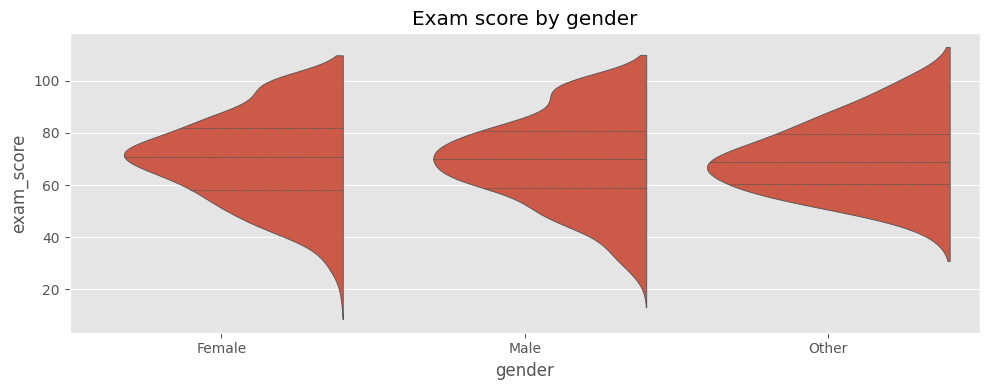

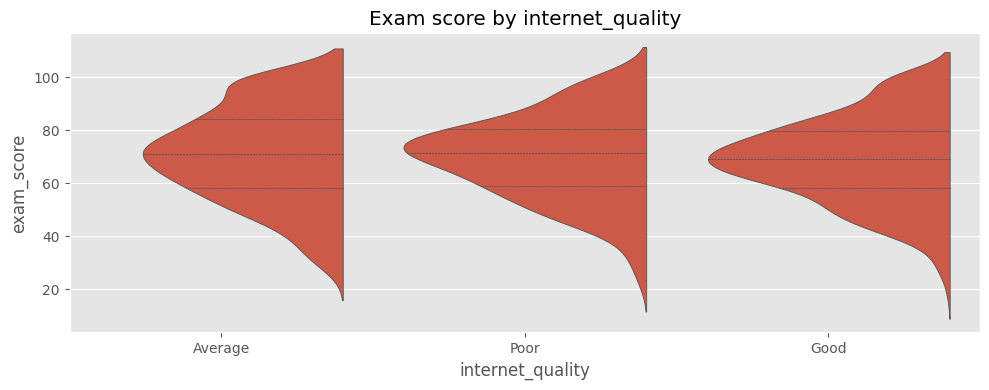

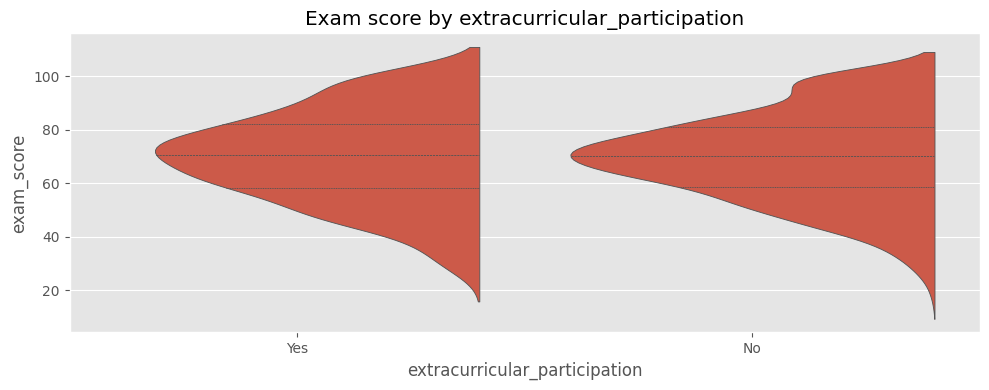

In [116]:
# Exam score distribution by category
cat_cols = ["gender","internet_quality", "extracurricular_participation"]
for col in cat_cols: 
    plt.figure(figsize=(10,4))
    sns.violinplot(x=col, y= "exam_score", data=df, inner="quartile", split=True)
    plt.title(f"Exam score by {col}")
    plt.tight_layout()
    plt.show()

# The student success ecosystem: A psychological reading of the data

Looking at this dataset is like being handed a psychological map of a student’s life. Exam scores are not just numbers; they are the final, visible outcome of a deep and complex interplay between a student's internal state and their external world. To understand what drives success, we must interpret these data points not just as metrics, but as clues to the underlying psychological forces at play.

1. ***The Cognitive Foundation: The Brain's Readiness to Learn***
Before any learning can happen, the brain must be in a state to receive and process information. This dataset gives us a direct window into this foundation.

- Psychological Insight: Factors like **sleep hours, mental health rating, diet, and exercise** aren't lifestyle choices; they are the biological regulators of cognitive function.

- **Sleep is not passive rest; it's an active process critical for memory consolidation**. Without adequate sleep, the brain cannot efficiently move information from short-term to long-term memory. A sleep-deprived student isn't just tired; they are cognitively impaired.

- **Mental Health** is a direct measure of available cognitive resources. Anxiety and depression act like a "cognitive tax," constantly consuming working memory and executive functions (like planning and impulse control), leaving fewer resources for studying.

- **Diet and exercise** regulate the neurochemicals that govern mood, energy, and sustained attention.

→ This isn't about being "healthy" in a vague sense. It's about having the fundamental brain chemistry and cognitive capacity required for the demanding task of learning.

2. ***The Finite Economy of Attention: The Daily Battle for Focus***

Every student operates within a finite economy of time and mental energy. This dataset maps out *the primary competitors for these limited resources*.

- Psychological Insight: This is a classic battle between **delayed gratification (study hours) and immediate reward (social media, Netflix)**.

- Digital platforms are engineered to provide short, powerful hits of dopamine, creating a dopamine-driven feedback loop. This **trains the brain to crave novelty and rapid task-switching**, making the sustained, **"deep work" required for genuine learning feel difficult and unrewarding**. 

- Commitments like a **part-time job** or **demanding extracurricular activities** are major drains on this finite mental energy. This isn't just about time lost; it's about the exhaustion that comes with that, along with the effort that gets used up throughout the day.
*A student working a 4-hour shift doesn't just lose 4 hours; they lose the cognitive energy needed to study effectively afterward.*

→ That said, extracurriculars can be a double-edged sword. While they consume time, they can also be a vital **source of eustress** (positive stress), social connection, and identity-building, which can bolster psychological resilience and buffer against academic burnout. The key is balance.

3. ***The Scaffolding of Success: Environment, Support, and Identity***

Finally, no student exists in a vacuum. Their success is profoundly shaped by the structural and social supports around them; or the lack thereof.

- Attendance percentage is a powerful behavioral signal. It's not the cause of failure, but a symptom of disengagement, which could stem from a low sense of belonging, overwhelming stress, or a feeling of being academically lost.

- Parental education level is a strong proxy for social capital and the "hidden curriculum" of academic success. **Students from backgrounds with higher parental education may have a built-in advantage in navigating the university system, managing expectations, and accessing support**. Those without this background need the institution to provide more explicit scaffolding.

- Internet quality is a modern-day equity issue that creates chronic, low-level friction. A student with poor internet experiences constant micro-frustrations that add to their overall cognitive load, making every academic task slightly harder.

- Demographics like age and gender are crucial lenses. The pressures of time management and mental health may manifest very differently for a first-year student still adapting to university life versus a senior preparing for the workforce. Similarly, societal pressures and coping mechanisms can vary by gender, influencing how students navigate these challenges.

# Actionable Synthesis

Our strategy cannot be one-dimensional. We must act as architects of a supportive ecosystem.
- **Prioritize Cognitive Readiness** → Frame wellness initiatives as "Cognitive Performance Programs." Give students the data and the psychological rationale: "Sleep more not just to feel better, but to learn faster."

- **Teach Attention Management, Not Just Time Management** → Run workshops on the psychology of focus and the dangers of cognitive fragmentation. Acknowledge the reality of ego depletion for working students and offer them flexible, high-impact support.

- **Build an Equitable Scaffolding** → Use data like **parental_education_level** and **internet_quality** to identify students who may need more proactive, structural support. Transform advisors into "ecosystem coaches" who can look at a student's entire profile; their sleep, their job, their mental health and provide a psychologically-informed guidance.